# Tutorial 8

In this tutorial, we will cover: 
* __**$\beta$ - VAE**__ : An extension to the standard Variational Autoencoder (VAE) that can learn disentangled representations. 
* **Introduction to BNNS**: Introduction to Bayesian Regression and Bayesian Neural Networks. 
* **Pyro**: Introduction to Pyro, a probabilistic programming package. 
* **Using Pyro to Train Probabilistic Models** Using Pyro to solve a simple inference problem with Variational Bayes, a Bayesian Regression problem and training a Bayesian Neural Network

# Refresher on Variational Autoencoders
We'll briefly go over the components of a Variational Autoencoder. 

__Problem Setup__: We have a dataset __$X = \{x^{(i)}\}^N_{i=1}$__ consisting of N i.i.d. (independent, identically distributed) samples. 

We assume: 
* __Data generation process:__ The data is generated by some random process, involving and unobserved continuous random variable __$z$__. This process involves: (1) first sampling the value $z^{i}$ from some prior $p_{\theta^{*}}(z)$ (2) generating $x^{i}$ using some conditional distribution $p_{\theta^{*}}(x|z)$. 
* __Parametric distributions:__ Both $p_{\theta^{*}}(x|z)$ and $p_{\theta^{*}}(z)$ come from some parametric families of distributions, and their PDFs are differentiable wrt. $x$ and $z$ almost everywhere. 

What we want (goals of training a VAE): 
* __Efficient approximate ML or MAP estimation for the parameters $\theta$__: We might be interested in analyzing the parameters themselves. Or we might want to generate artificial data that resembles real data. How could this be used? 
* __Efficient approximate posterior inference__: Given $x$, what is the posterior (updated) distribution over $z$? ($p_{\theta^{*}}(z|x)$) Why might we be interested in this? Answer: coding or representation learning problems. 
* __Effective approximate marginal inference on $x$__: This is useful for tasks in which a prior over x is required. Examples include image denoising, impainting and super-resolution. 

__VAE Objective__
You've seen how the VAE objective comes up when trying to compute $p_{\theta}(\mathbf{z}|\mathbf{x})$. This is the second goal of VAE training listed above. We recognized that an intractible integral emerges. We reframed this instead as an optimization problem where we train a parametric model to approximate the posterior under the KL divergence objective. 

We will now derive the VAE loss emerges when we try to maximize the (marginal) likelihood of the observed data. This is the first goal of the VAE training listed above. Lets express the training objective: 

\begin{align*}
\max_{\theta}\log(p_{theta}(\mathbf{x})) & = \max_{\theta} \log(\int_{z}p_{\theta}(\mathbf{x}, \mathbf{z}) d\mathbf{z})\\ &= \max_{\theta}log(\int_{z}p_{\theta}(\mathbf{x} | \mathbf{z}) p_{\theta}(\mathbf{z})  d\mathbf{z} )\\ & = \max_{\theta} \log( \mathop{\mathbb{E}}_{z \sim p_{\theta}(\mathbf{z})} [p_{\theta}(\mathbf{x} | \mathbf{z})] )
\end{align*}

Note that this expectation is over our prior $p_{\theta}(\mathbf{z})$, which is not informed by observed data $\mathbf{x}$!  We'd need a huge number of samples from z to get a good estimate of this expectation. Could we sample the latent codes more intelligently so that the problem becomes tractable? 

We can move the expectation over a new distribution $q_{\phi}(\mathbf{z}|x)$ so that we always sample latent codes that are likely to have generated the data we are training our model on. Before we move on to deriving the VAE loss, here's a reminder of the Jensen inequality: If X is a random variable and f is a convex function, then:

\begin{equation}
\mathop{\mathbb{E}}[f(X)] \leq f(\mathop{\mathbb{E}}[x]) 
\end{equation}

Back to deriving the VAE loss: 


\begin{align*}
\max_{\theta}\log(p_{theta}(\mathbf{x})) & =\max_{\theta} \log(\int_{z}p_{\theta}(\mathbf{x}, \mathbf{z}) d\mathbf{z})\\ 
&= \max_{\theta}\log(\int_{z}p_{\theta}(\mathbf{x} | \mathbf{z}) p_{\theta}(\mathbf{z})  d\mathbf{z} )\\ 
&= \max_{\theta}\log(\int_{z}p_{\theta}(\mathbf{x} | \mathbf{z}) p_{\theta}(\mathbf{z}) \frac{q_{\phi}(\mathbf{z} |\mathbf{x} )}{q_{\phi}(\mathbf{z} |\mathbf{x} )}  d\mathbf{z} )\\ 
&= \max_{\theta}\log(\int_{z} q_{\phi}(\mathbf{z} |\mathbf{x} )  \frac{p_{\theta}(\mathbf{x} | \mathbf{z}) p_{\theta}(\mathbf{z})}{q_{\phi}(\mathbf{z} |\mathbf{x} )}  d\mathbf{z} )\\ 
& \geq \max_{\theta}\int_{z} q_{\phi}(\mathbf{x} |\mathbf{z} )  \log(\frac{p_{\theta}(\mathbf{x} | \mathbf{z}) p_{\theta}(\mathbf{z})}{q_{\phi}(\mathbf{x} |\mathbf{z} )})  d\mathbf{z}\\ 
&= \mathop{\mathbb{E}}_{z \sim q_{\phi}(\mathbf{z} | \mathbf{x})}[\log{p_{\theta}(\mathbf{x} | \mathbf{z})}] - KL[q_{\phi}(\mathbf{z} | \mathbf{x}) || p_{\theta}(\mathbf{z})]
\end{align*}

We've arrived at what is called evidence lower bound (ELBO), variational lower bound, or variational free energy. This is the loss function we use to train VAEs. We can now move on to $\beta$-VAEs. 

# __**$\beta$ - VAE**__ to Learn Disentangled Representations

Imagine you want to write an app that can generate all kinds of human faces based on user specifications. With as little number of sliders, you'd like to be able to generate as many different faces. What characteristics of a human face would your sliders control? An important question in representation learning is to learn these types of characteristics from data in an unsupervised fashion. 

Back to the question above: potential characteristics of a human face could include hair color, gender, age, skin color, etc. Note two things: 1) you can modify each of these characteristics of a human face without altering the others much, i.e. they are **factorised/disentangled**. 2) you are forced to come up with factorised representations if you restrict the number of "sliders" you are using (in other words, **restricting you channel capacity**). $\beta$-VAE proposes a simple alteration to the standard VAE objective to learn such disentanbled representations. 
 
 Disentangled representations are useful in a variety of ways: knowledge transfer, few-shot inference, novelty detection and of course learning humanly-controllable generative models. 


__$\beta$-VAE Objective__
Consider the second term in the VAE objective: $KL[q_{\phi}(\mathbf{z} | \mathbf{x}) || p_{\theta}(\mathbf{z})]$. Informally, this term acts a regularizer on the conditional latent code distribution by forcing it to remain close to the prior we set to it. 

The core idea behind the $\beta$-VAE loss is use this regularization term to encourage the learning of disentangled representations. Specifically, if we choose an isotropic unit Gaussian as our prior (where there are no correlation between the units), we can encourage our model to learn disentangled representations. How do we control how strongly we enforce the regularization term? By scaling it with a constant $\beta$!
\begin{equation*}
\mathcal{L}_{\beta -VAE} =  \mathop{\mathbb{E}}_{z \sim p_{\phi}}(\mathbf{z} | \mathbf{x})[p_{\theta}(\mathbf{x} | \mathbf{z})] - \beta * KL[q_{\phi}(\mathbf{z} | \mathbf{x}) || p_{\theta}(\mathbf{z})]
\end{equation*}



__Quantifying Disentanglement__ How do we know when we've learned disentangled representations? One way is to use the generator to observe the effect of changing the values of latent codes one by one. When we do this for $\beta$-VAE, we get results like this (trained on CelebA, faces and chairs): 

![Faces](faces.png)
![Chairs1](chairs1.png)
![Chairs2](chairs2.png)

One of the main contributions of the $\beta$ VAE paper is a method to quantify disentanglement. Those interested can find more information about this in the paper (listed in the referneces below).

# Bayesian Neural Networks

Standard neural networks have fixed weights and biases. They can only output point estimates rather than distributions. With Bayesian methods (including Bayesian Neural Networks), we obtain a distribution of answers to a question. 

__Important Remark__: It is helpful to recognize that delineate the difference between "models" and "algorithms". "Bayesian" belongs to the Algorithms category, not the model category. Any well defined model can be treated in a Bayesian manner. [6]

![Algo](algo_vs_model.png)

The following figure compares the standard neural networks with Bayesian neural nets. 

![nn_vs_bnn](nn_vs_bnn.png)

__Why care?__
* __Calibrated uncertainty__: The output of the model is a distribution, which lets us put error bars on our predictions. 

\begin{equation*}
P(\mathbf{y}|\mathbf{x},\mathbf{D}) = \int_{\mathbf{w}} P(\mathbf{y}|\mathbf{w}, \mathbf{x})P(\mathbf{w} | \mathbf{D}) d\mathbf{w} = \mathop{\mathbb{E}}_{\mathbf{w} \sim p(\mathbf{w} | \mathbf{D})}[p(\mathbf{y}|\mathbf{w}, \mathbf{x})]
\end{equation*}

__How do we train?__
There are various ways to train BNNs. Approaches include Monte Carlo methods (Markov Chain Monte Carlo, Hamiltonian Monte Carlo), Variational Bayes. We will focus on the latter one in this tutorial. 

Here are some reasons why Variational Bayes has been gaining popularity over the past years: 
* Can scale up to large data, lage dimensions. 
* Variational Bayes can be fast.  

Just like we did when training VAEs, we will convert the intractible integration into an optimization problem and minimize the KL divergence between the posterior and a proposed parametric function. 

Now, a short introduction to Pyro. 

# Pyro: A Probabilistic Programming Library

Pyro is a probabilistic programming module based off of PyTorch. We will first begin with exploring the Pyro primitives. Then, we will follow two tutorials presented in the Pyro documentation to learn how we can perform inference and Bayesian regression using Pyro. 

# Introduction to Models in Pyro

In [1]:
import torch
import pyro

pyro.set_rng_seed(101)

The basic unit of probabilistic programs is the stochastic function. This is a python collable that contains deterministic Python code and other primitive stochastic functions that call a random number generator.

__Primitive Stochastic Functions__: These are stochastic functions whose output probabilities can be explicitly computed given inputs. Here is a simple example: 

In [2]:
loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object

# We can sample as many times as we want. 
num_samples = 5
for _ in range(num_samples):
    x = normal.rsample() # draw a sample from N(0,1)
    print("sample", x)
    print("log prob", normal.log_prob(x)) # score the sample from N(0,1)

sample tensor(-1.3905)
log prob tensor(-1.8857)
sample tensor(-0.8152)
log prob tensor(-1.2512)
sample tensor(-0.3204)
log prob tensor(-0.9703)
sample tensor(0.7377)
log prob tensor(-1.1911)
sample tensor(-1.7534)
log prob tensor(-2.4561)


__Building Models using Primitive Stochastic Functions__: We can build models by simply combining primitive stochastic functions. 

In [3]:
def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

__Pyro Equivalents of the Above__ So far, we've been using the utilities of PyTorch to construct stochastic functions. We now turn to how this is done using Pyro.

In [4]:
x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x)

tensor(0.6033)


Almost the same, with one important distinction:  Sample statements are named. This is important, because this way Pyro recognizes that weather() induces a joint probability distribution. This will come in handy later on when we deal with conditioning. 

In [6]:
def weather():
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

num_samples = 3
for _ in range(num_samples):
    print(weather())

('sunny', 58.44780731201172)
('sunny', 80.37315368652344)
('sunny', 101.10397338867188)


We can combine/compose stochastic functions to build even more complex stochastic functions. 

In [7]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return ice_cream

Pyro lets us do recursion as well. We can sample from a geometric distribution this way. One caveat: We have to be careful about the sample statements as we do recursion.

In [8]:
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)

num_samples = 5
for _ in range(5):
    print(geometric(0.2))

24
0
0
6
0


We can even accept as input, or produce as output other stochastic functions. 

In [9]:
def normal_product(loc, scale):
    z1 = pyro.sample("z1", pyro.distributions.Normal(loc, scale))
    z2 = pyro.sample("z2", pyro.distributions.Normal(loc, scale))
    y = z1 * z2
    return y

def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", pyro.distributions.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn

print(make_normal_normal()(1.))

tensor(-0.5879)


__Universality__ Thanks to all these things Pyro supports, we can express any stochastic function there could be. In other words, Pyro stochastic functions are *universal*.

## Inference in Pyro

Here, we are going to use Pyro to solve a simple inference problem. (based on Pyro documentation, worked examples)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

Lets say we're trying to estimate the weight of an object using an unreliable scale and our prior knowledge about how much the object could be weighing. We model this process as follows: 
\begin{align*}
&P(weight | guess) \sim \mathcal{N}(guess, 1.) \\
&P(measurement | guess, weight) \sim \mathcal{N}(weight, 0.75)
\end{align*}
We now code this process using Pyro. 

In [11]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

__Conditioning__
"The real utility of probabilistic programming is in the ability to condition generative models on observed data and infer the latent factors that might have produced that data." 

Pyro makes this kind of computation convenient by separating the expression of conditining from its evaluation via inference. We can create a model once, and condition it on different observations. 

Lets say we've made a measurement. The question is how to obtain the posterior distribution of the weights given the guess and the measurement ($P(weight | guess, measurement=m)$) We can condition our model on a particular measurement as follows: 

In [14]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

# Below is equivalent to the following. 
def scale_obs(guess): 
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 1.), obs=9.5)

We can also defer conditioning: 

In [15]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)

__Parametrized Stochastic Functions and Variational Inference__ The problem posed above is actually very simple: there exists a closed form posterior that we can compute analytically. This is the exception rathen the rule, though. In most cases, the full Bayesian inference isn't available due to intractiable integrals. (remember the case in VAEs)

In [16]:
def correct_posterior(guess):
    loc =(0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))

In [14]:
def intractable_scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(some_nonlinear_function(weight), 0.75))

**Variational Bayes to the rescue**  Just like what we did in VAEs, we can turn the integration into an optimization problem. We will introduce a parameterized stochastic function (called a **guide** in Pyro, in the context of variational inference) and optimize its parameters so that it approximates the intractible posterior we are trying to compute. In this problem, we can use a Gaussian as our guide, whose mean and variance will be our parameters. 

(Note how easy Pyro makes it to impose constraints on parameters)

In [17]:
from torch.distributions import constraints

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs

We are ready to optimize the parameters of our guide! Pyro makes it possible to use built-in optimizers, such as Stochastic Variational Inference. This algorithm computes Monte Carlo estimates of a loss function (ELBO in this case) from samples of execution histories of the model and guide, and uses stochastic gradient descent to search for the optimal parameters. 

/Users/cemanil/anaconda2/envs/pyro_3_5/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


a =  9.107148170471191
b =  0.606410026550293


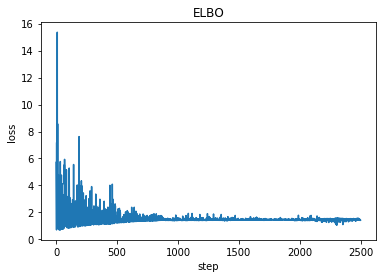

In [18]:
guess = torch.tensor(8.5)

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide_constrained,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

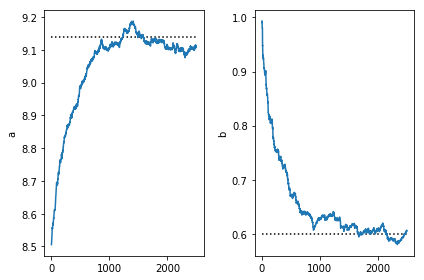

In [19]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

As our guide was actually chosen to be from the correct family of functions, we can optimize the parameters to come quite close to the correct values. 

# Warm-Up to BNNs: Bayesian Linear Regression

Lets start by solving a simple linear regression problem (the non Bayesian way). We will then implement Bayesian linear regression using Pyro, which will let us assign error bars to our estimates. 

In [20]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta, MultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

# for CI testing
smoke_test = ('CI' in os.environ)
# assert pyro.__version__.startswith('0.3.0')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

Our small dataset consists of three columns: 1) whether a country is in Africa or not, 2)  a quantitative measure of terrain ruggedness 3) GDP per capita. 

In [21]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
print(df[0:10])

    cont_africa  rugged  rgdppc_2000
2             1   0.858     7.492609
4             0   3.427     8.216929
7             0   0.769     9.933263
8             0   0.775     9.407032
9             0   2.688     7.792343
11            0   0.006     9.212541
12            0   0.143    10.143191
13            0   3.513    10.274632
14            0   1.672     7.852028
15            1   1.780     6.432380


[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

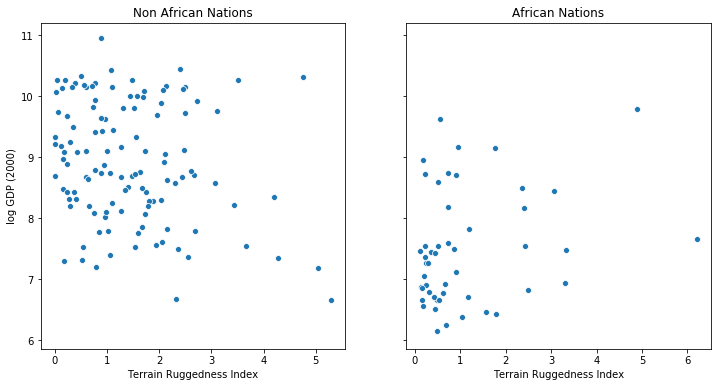

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = data[data["cont_africa"] == 1]
non_african_nations = data[data["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            np.log(non_african_nations["rgdppc_2000"]),
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
            np.log(african_nations["rgdppc_2000"]),
            ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

Now we build a simple regression model and train it. Note that we've added a new feature to capture the correlation between whether a country is in Africa and terrain ruggedness. 

In [24]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)
        self.factor = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.linear(x) + (self.factor * x[:, 0] * x[:, 1]).unsqueeze(1)
        # return self.linear(x)# + (self.factor * x[:, 0] * x[:, 1]).unsqueeze(1)

p = 2  # number of features
regression_model = RegressionModel(p)

In [25]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(regression_model.parameters(), lr=0.05)
num_iterations = 2000 if not smoke_test else 2
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

def main():
    x_data = data[:, :-1]
    y_data = data[:, -1]
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = regression_model(x_data).squeeze(-1)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in regression_model.named_parameters():
        print(name, param.data.numpy())

main()

[iteration 0050] loss: 3723.7849
[iteration 0100] loss: 1777.9851
[iteration 0150] loss: 1226.7543
[iteration 0200] loss: 927.1514
[iteration 0250] loss: 706.6473
[iteration 0300] loss: 536.0911
[iteration 0350] loss: 408.0940
[iteration 0400] loss: 316.1810
[iteration 0450] loss: 252.9711
[iteration 0500] loss: 211.2545
[iteration 0550] loss: 184.7950
[iteration 0600] loss: 168.6502
[iteration 0650] loss: 159.1673
[iteration 0700] loss: 153.8036
[iteration 0750] loss: 150.8815
[iteration 0800] loss: 149.3482
[iteration 0850] loss: 148.5732
[iteration 0900] loss: 148.1960
[iteration 0950] loss: 148.0193
[iteration 1000] loss: 147.9397
[iteration 1050] loss: 147.9051
[iteration 1100] loss: 147.8907
[iteration 1150] loss: 147.8850
[iteration 1200] loss: 147.8828
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8816
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
[iteration 1550] loss: 147.8815
[iter

__Bayesian Regression__ In the Bayesian regression setting, all the parameters have prior distributions on them. 

In [26]:
def model(x_data, y_data):
    # weight and bias priors
    w_prior = Normal(torch.zeros(1, 2), torch.ones(1, 2)).to_event(1)
    b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)
    f_prior = Normal(0., 1.0)
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior, 'factor': f_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    
    # sample a nn (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    # Construct a conditionally independent sequence of variables. 
    scale = pyro.sample("sigma", Uniform(0., 10.))
    with pyro.plate("map", len(x_data)):
        # run the nn forward on data
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, scale),
                    obs=y_data)
        return prediction_mean

In order to do inference we’re going to need a guide, i.e. a variational family of distributions. We will use Pyro’s autoguide library to automatically place Gaussians with diagonal covariance on all of the distributions in the model. Under the hood, this defines a guide function with Normal distributions with learnable parameters corresponding to each sample() in the model. 

In [27]:
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

In [28]:
optim = Adam({"lr": 0.03})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=1000)

In [29]:
def train():
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
        if j % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

train()


[iteration 0001] loss: 9.2610
[iteration 0101] loss: 3.3847
[iteration 0201] loss: 3.2205
[iteration 0301] loss: 3.2195
[iteration 0401] loss: 2.7919
[iteration 0501] loss: 2.6671
[iteration 0601] loss: 2.4354
[iteration 0701] loss: 2.2640
[iteration 0801] loss: 1.8932
[iteration 0901] loss: 2.0145
[iteration 1001] loss: 1.4908
[iteration 1101] loss: 1.5649
[iteration 1201] loss: 1.5285
[iteration 1301] loss: 1.4955
[iteration 1401] loss: 1.5362
[iteration 1501] loss: 1.4865
[iteration 1601] loss: 1.5018
[iteration 1701] loss: 1.4958
[iteration 1801] loss: 1.4760
[iteration 1901] loss: 1.4784


In [30]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([ 0.3940, -1.8259, -0.1268,  9.2204, -2.2107], requires_grad=True)
auto_scale tensor([0.0826, 0.1328, 0.0474, 0.0737, 0.1229], grad_fn=<AddBackward0>)


In [31]:
get_marginal = lambda traces, sites: EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))

posterior = svi.run(x_data, y_data)

In [32]:
# posterior predictive distribution we can get samples from
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

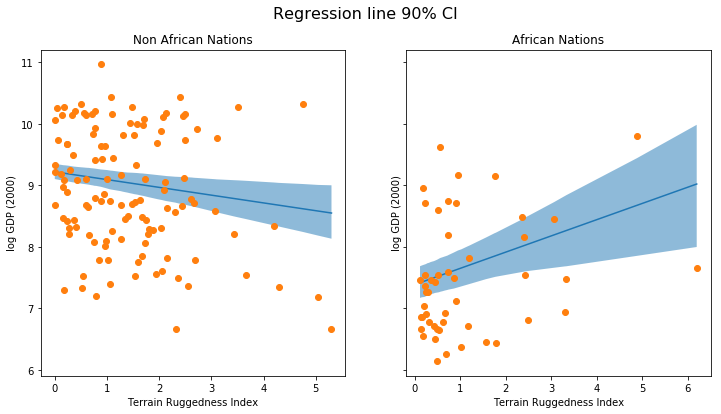

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

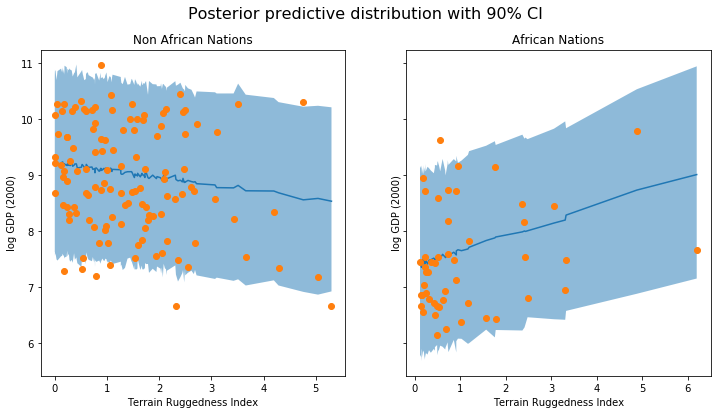

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

__BNNs__ We are finally ready to implement a BNN. All we need to do is to update our regression model to a neural network, and modify our guide (which Pyro is designed to do automatically). 

In [1]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta, MultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

# for CI testing
smoke_test = ('CI' in os.environ)
# assert pyro.__version__.startswith('0.3.0')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

In [2]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
print(df[0:10])

    cont_africa  rugged  rgdppc_2000
2             1   0.858     7.492609
4             0   3.427     8.216929
7             0   0.769     9.933263
8             0   0.775     9.407032
9             0   2.688     7.792343
11            0   0.006     9.212541
12            0   0.143    10.143191
13            0   3.513    10.274632
14            0   1.672     7.852028
15            1   1.780     6.432380


[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

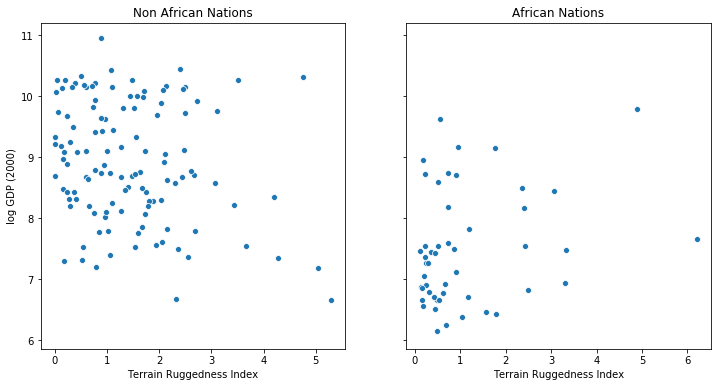

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = data[data["cont_africa"] == 1]
non_african_nations = data[data["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            np.log(non_african_nations["rgdppc_2000"]),
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
            np.log(african_nations["rgdppc_2000"]),
            ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

Define a very small neural network. 

In [4]:
from torch.functional import F

class RegressionNN(nn.Module):
    def __init__(self, p, hidden):
        # p = number of features
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(p, hidden)
        self.fc2 = nn.Linear(hidden, 1)
        self.factor = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        z1 = self.fc1(x)+ (self.factor * x[:, 0] * x[:, 1]).unsqueeze(1)
        h1 = torch.tanh(z1)
        z2 = self.fc2(h1) 
        
        return z2

p = 2  # number of features
hidden = 4 # number of hidden units
nnet = RegressionNN(p, hidden)

First, train it the non-Bayesian way. 

In [5]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(nnet.parameters(), lr=0.05)
num_iterations = 3000 if not smoke_test else 2
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

def main():
    x_data = data[:, :-1]
    y_data = data[:, -1]
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = nnet(x_data).squeeze(-1)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in nnet.named_parameters():
        print(name, param.data.numpy())

main()

[iteration 0050] loss: 286.6575
[iteration 0100] loss: 240.2293
[iteration 0150] loss: 232.2536
[iteration 0200] loss: 162.0223
[iteration 0250] loss: 158.2430
[iteration 0300] loss: 157.5087
[iteration 0350] loss: 156.9830
[iteration 0400] loss: 156.5809
[iteration 0450] loss: 156.2632
[iteration 0500] loss: 156.0058
[iteration 0550] loss: 155.7933
[iteration 0600] loss: 155.6149
[iteration 0650] loss: 155.4633
[iteration 0700] loss: 155.3329
[iteration 0750] loss: 155.2197
[iteration 0800] loss: 155.1205
[iteration 0850] loss: 155.0332
[iteration 0900] loss: 154.9556
[iteration 0950] loss: 154.8864
[iteration 1000] loss: 154.8243
[iteration 1050] loss: 154.7683
[iteration 1100] loss: 154.7176
[iteration 1150] loss: 154.6715
[iteration 1200] loss: 154.6295
[iteration 1250] loss: 154.5910
[iteration 1300] loss: 154.5557
[iteration 1350] loss: 154.5232
[iteration 1400] loss: 154.4932
[iteration 1450] loss: 154.4655
[iteration 1500] loss: 154.4397
[iteration 1550] loss: 154.4158
[iterati

Now we "lift" the variables to be random variables. 

In [6]:
def bnn_model(x_data, y_data):
    # weight and bias priors
    fc1w_prior = Normal(torch.zeros(hidden, 2), torch.ones(hidden, 2)).to_event(2)
    fc1b_prior = Normal(torch.tensor([[0.]]), torch.tensor([[1000.0]])).to_event(2)
    
    fc2w_prior = Normal(torch.zeros(1, hidden), torch.ones(1, hidden)).to_event(2)
    fc2b_prior = Normal(torch.tensor([[0.]]), torch.tensor([[1000.]])).to_event(2)
    
    f_prior = Normal(0., 1.0)

    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'fc2.weight': fc2w_prior, 
              'fc2.bias': fc2b_prior, 'factor': f_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", nnet, priors)
    
    # sample a nn (which also samples w and b)
    lifted_reg_nn = lifted_module()
    
    # Construct a conditionally independent sequence of variables. 
    scale = pyro.sample("sigma", Uniform(0., 10.))
    with pyro.plate("map", len(x_data)) as ind:
        # run the nn forward on data
        prediction_mean = lifted_reg_nn(x_data[ind]).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, scale),
                    obs=y_data)
        return prediction_mean

Now we define our guide. 

In [7]:
from pyro.contrib.autoguide import AutoDiagonalNormal
bnn_guide = AutoDiagonalNormal(bnn_model)

# softplus = torch.nn.Softplus()


# To see what the guide looks like inside. 
# def bnn_guide(x_data, y_data):
    
#     # First layer weight distribution priors
#     fc1w_mu = torch.randn_like(nnet.fc1.weight)
#     fc1w_sigma = torch.randn_like(nnet.fc1.weight)
#     fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
#     fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
#     fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    
#     # First layer bias distribution priors
#     fc1b_mu = torch.randn_like(nnet.fc1.bias)
#     fc1b_sigma = torch.randn_like(nnet.fc1.bias)
#     fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
#     fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
#     fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    
#     # Output layer weight distribution priors
#     fc2w_mu = torch.randn_like(nnet.fc2.weight)
#     fc2w_sigma = torch.randn_like(nnet.fc2.weight)
#     fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
#     fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
#     fc2w_prior = Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param).independent(1)
    
#     # Output layer bias distribution priors
#     fc2b_mu = torch.randn_like(nnet.fc2.bias)
#     fc2b_sigma = torch.randn_like(nnet.fc2.bias)
#     fc2b_mu_param = pyro.param("outb_mu", fc2b_mu)
#     fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
#     fc2b_prior = Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)
#     priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior}
    
#     lifted_module = pyro.random_module("module", nnet, priors)
    
#     return lifted_module()

In [9]:
bnn_optim = Adam({"lr": 0.02})
bnn_svi = SVI(bnn_model, bnn_guide, bnn_optim, loss=Trace_ELBO(), num_samples=1000)

In [10]:
num_iterations = 2500
def bnn_train():
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = bnn_svi.step(x_data, y_data)
        if j % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

bnn_train()


[iteration 0001] loss: 3.5865
[iteration 0101] loss: 3.4459
[iteration 0201] loss: 3.5227
[iteration 0301] loss: 3.5579
[iteration 0401] loss: 3.0233
[iteration 0501] loss: 2.9926
[iteration 0601] loss: 2.8840
[iteration 0701] loss: 2.2529
[iteration 0801] loss: 2.9034
[iteration 0901] loss: 2.1656
[iteration 1001] loss: 2.1560
[iteration 1101] loss: 1.9120
[iteration 1201] loss: 1.8741
[iteration 1301] loss: 1.9284
[iteration 1401] loss: 2.0538
[iteration 1501] loss: 1.6295
[iteration 1601] loss: 1.7347
[iteration 1701] loss: 1.6458
[iteration 1801] loss: 1.6659
[iteration 1901] loss: 1.6224
[iteration 2001] loss: 1.6449
[iteration 2101] loss: 1.6512
[iteration 2201] loss: 1.6321
[iteration 2301] loss: 1.6429
[iteration 2401] loss: 1.6710


In [10]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([ 0.3045, -3.0114, -0.4948,  0.0919,  0.9000,  0.1420,  0.7248,  0.1129,
         0.8217,  2.0911,  0.8226,  1.2751,  0.9123,  1.4853,  4.5585, -2.2139],
       requires_grad=True)
auto_scale tensor([0.3016, 0.3470, 0.0991, 0.7576, 0.3562, 0.8013, 0.4589, 0.7648, 0.4242,
        0.1822, 0.0920, 0.0706, 0.0768, 0.0724, 0.0739, 0.1333],
       grad_fn=<AddBackward0>)


In [11]:
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def bnn_summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def bnn_wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(bnn_model(x_data, y_data)))

bnn_posterior = bnn_svi.run(x_data, y_data)

In [13]:
# posterior predictive distribution we can get samples from
bnn_trace_pred = TracePredictive(bnn_wrapped_model,
                                 bnn_posterior,
                                 num_samples=1000)
bnn_post_pred = bnn_trace_pred.run(x_data, None)
bnn_post_summary = bnn_summary(bnn_post_pred, sites= ['prediction', 'obs'])
bnn_mu = bnn_post_summary["prediction"]
bnn_y = bnn_post_summary["obs"]
bnn_predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": bnn_mu["mean"],
    "mu_perc_5": bnn_mu["5%"],
    "mu_perc_95": bnn_mu["95%"],
    "y_mean": bnn_y["mean"],
    "y_perc_5": bnn_y["5%"],
    "y_perc_95": bnn_y["95%"],
    "true_gdp": y_data,
})

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

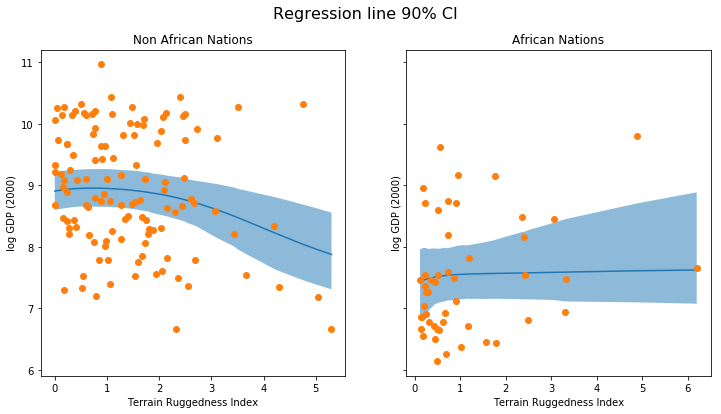

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = bnn_predictions[bnn_predictions["cont_africa"] == 1]
non_african_nations = bnn_predictions[bnn_predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

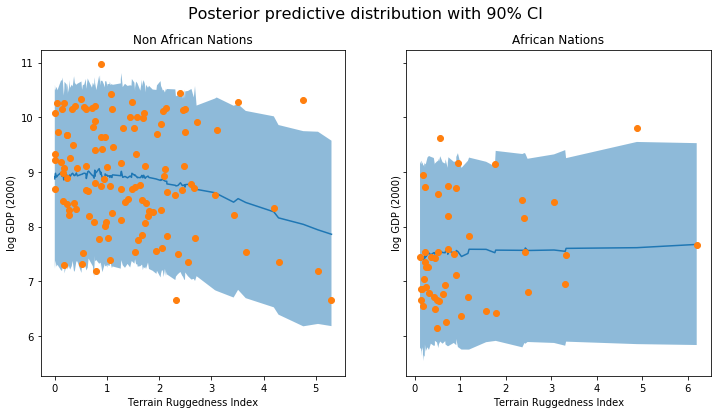

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

## References

[1] Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.https://arxiv.org/abs/1312.6114 

[2] Higgins, I., Matthey, L., Pal, A., Burgess, C., Glorot, X., Botvinick, M., ... & Lerchner, A. (2017). beta-vae: Learning basic visual concepts with a constrained variational framework. In International Conference on Learning Representations

[3] From Autoencoder to Beta-VAE, Lilian Weng, https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

[4] CSC421 (2019) Course Notes http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/

[5] CSC2541 (2017) Course Notes https://csc2541-f17.github.io 

[6] Zoubin Ghahramani, History of Bayesian Neural Networks (NIPS 2016) https://www.youtube.com/watch?v=v1BTHd5HXYE

[7] Pyro Documentation, Examples. http://pyro.ai/examples/intro_part_i.html 

[8] Making Your Neural Network Say “I Don’t Know” — Bayesian NNs using Pyro and PyTorch, Paras Chopra, https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd

[9] Variational Bayes and Beyond, ICML 2018 Tutorial, Tamara Broderick, https://www.youtube.com/watch?v=Moo4-KR5qNg 

[10] Functional Variational Bayesian Neural Networks, ICLR 2019, Shengyang Sun, Guodong Zhang, Jiaxin Shi, Roger Grosse, https://arxiv.org/pdf/1903.05779.pdf 

## More on the BNN Training Setup [10]

![fvbnn](fvbnn.png)